# Graph Neural Network for prediction of displacement in a cantilever beam problem


##Import libraries

In [ ]:
import csv
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape, Dense
#for visualisation
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
!pip install visualkeras
import visualkeras
from keras.utils import plot_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 26.6 MB/s eta 0:00:00


## Build dataset

In [ ]:
displacement = pd.read_csv('/content/displacementc.csv')
properties = pd.read_csv('/content/propertiesc.csv')

In [ ]:
data = []
headers = ['iteration'] + list(displacement.columns) + list(properties.columns[2:-1]) + ['E1','E2','E3','E4']
combine = pd.DataFrame(data, columns=headers)

In [ ]:
dt = []
for i in range(displacement.shape[0]//451):
  poisson = (properties.loc[(properties['iteration']==i+1),'poisson'])[0+(100*i)]
  for j in range(451):
    x = ((displacement.iloc[i+j]).tolist())[1]
    y = ((displacement.iloc[i+j]).tolist())[2]
    #horizontal border elements
    if y==0: #bottom
      if x<10:
        E1 = (properties.loc[(properties['element']==(y//0.2)+(x//0.5)*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        if x>0:
          E2 = (properties.loc[(properties['element']==(y//0.2)+(x//0.5-1+((x%0.5)*4))*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        else: #left corner
          E2 = E1
        E3 = E4 = E1
      else: #right corner
        E2 = (properties.loc[(properties['element']==(y//0.2)+(x//0.5-1+((x%0.5)*4))*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        E1 = E3 = E4 = E2
    elif y==1: #top
      if x<10:
        E4 = (properties.loc[(properties['element']==(y//0.2-1+((y*10%2)))+(x//0.5)*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        if x>0:
          E3 = (properties.loc[(properties['element']==(y//0.2-1+((y*10%2)))+(x//0.5-1+((x%0.5)*4))*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        else: #left corner
          E3 = E4
        E1 = E2 = E4
      else: #right corner
        E3 = (properties.loc[(properties['element']==(y//0.2-1+((y*10%2)))+(x//0.5-1+((x%0.5)*4))*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        E1 = E4 = E2 = E3
    #vertical border elements
    elif x==0: #left
      if y<1:
        E1 = (properties.loc[(properties['element']==(y//0.2)+(x//0.5)*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        E4 = (properties.loc[(properties['element']==(y//0.2-1+(((y*10)%2)))+(x//0.5)*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        E3 = E2 = E1
    elif x==10: #right
      if y<1:
        E2 = (properties.loc[(properties['element']==(y//0.2)+(x//0.5-1+((x%0.5)*4))*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        E3 = (properties.loc[(properties['element']==(y//0.2-1+((y*10%2)))+(x//0.5-1+((x%0.5)*4))*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
        E1 = E4 = E2
    else:
      E1 = (properties.loc[(properties['element']==(y//0.2)+(x//0.5)*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
      E2 = (properties.loc[(properties['element']==(y//0.2)+(x//0.5-1+((x%0.5)*4))*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
      E3 = (properties.loc[(properties['element']==(y//0.2-1+(((y*10)%2)))+(x//0.5-1+((x%0.5)*4))*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
      E4 = (properties.loc[(properties['element']==(y//0.2-1+(((y*10)%2)))+(x//0.5)*5+1)&(properties['iteration']==i+1),'Youngs Modulus']).tolist()[0]
    dt.append([i+1]+((displacement.iloc[(451*i)+j]).tolist())+[poisson,E1,E2,E3,E4])

In [ ]:
combine = pd.DataFrame(dt, columns=headers)

## Data Visualisation

In [ ]:
df = pd.read_csv('/content/actualdata.csv')

In [ ]:
print(displacement.head())

   nodeno   X-co   Y-co   Ux   Uy
0       1    0.0    0.0  0.0  0.0
1       2    0.0    0.1  0.0  0.0
2       3    0.0    0.2  0.0  0.0
3       4    0.0    0.3  0.0  0.0
4       5    0.0    0.4  0.0  0.0


In [ ]:
print(properties.head())

   iteration  element  poisson  Youngs Modulus
0          1        1     0.45    7.000000e+10
1          1        2     0.45    7.000000e+10
2          1        3     0.45    7.000000e+10
3          1        4     0.45    7.000000e+10
4          1        5     0.45    7.000000e+10


In [ ]:
print(df.head())

   Unnamed: 0  iteration  nodeno   X-co   Y-co   Ux   Uy  poisson  \
0           0          1     1.0    0.0    0.0  0.0  0.0     0.45   
1           1          1     2.0    0.0    0.1  0.0  0.0     0.45   
2           2          1     3.0    0.0    0.2  0.0  0.0     0.45   
3           3          1     4.0    0.0    0.3  0.0  0.0     0.45   
4           4          1     5.0    0.0    0.4  0.0  0.0     0.45   

             E1            E2            E3            E4  
0  7.000000e+10  7.000000e+10  7.000000e+10  7.000000e+10  
1  7.000000e+10  7.000000e+10  7.000000e+10  7.000000e+10  
2  7.000000e+10  7.000000e+10  7.000000e+10  7.000000e+10  
3  7.000000e+10  7.000000e+10  7.000000e+10  7.000000e+10  
4  7.000000e+10  7.000000e+10  7.000000e+10  7.000000e+10  


### Exploratory Data Analysis

In [ ]:
df.describe().T.style.bar( subset=['mean'],color='#606ff2').background_gradient(
    subset=['std'], cmap='PuBu').background_gradient(subset=['50%'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,4510.000000,2254.500000,1302.069187,0.000000,1127.250000,2254.500000,3381.750000,4509.000000
iteration,4510.000000,5.500000,2.872600,1.000000,3.000000,5.500000,8.000000,10.000000
nodeno,4510.000000,226.000000,130.206602,1.000000,113.000000,226.000000,339.000000,451.000000
X-co,4510.000000,5.000000,2.958368,0.000000,2.500000,5.000000,7.500000,10.000000
Y-co,4510.000000,0.500000,0.316263,0.000000,0.200000,0.500000,0.800000,1.000000
Ux,4510.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000
Uy,4510.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
poisson,4510.000000,0.450000,0.000000,0.450000,0.450000,0.450000,0.450000,0.450000
E1,4510.000000,69999999999.956573,1.504130,69999999995.297806,69999999998.897644,69999999999.862793,70000000001.024658,70000000004.388840
E2,4510.000000,69999999999.956711,1.503639,69999999995.297806,69999999998.903275,69999999999.866791,70000000001.012833,70000000004.388840


In [ ]:
fig = px.scatter_3d(df, x=' X-co', y=' Y-co',z='Uy', color='E1', template='plotly_dark', title='Effect of position on U-y')
fig.show()

In [ ]:
fig = px.scatter_3d(df, x=' X-co', y=' Y-co',z='Ux', color='E1', template='plotly_dark', title='Effect of position on U-x')
fig.show()

In [ ]:
fig = px.imshow(df.corr(), template='plotly_dark', title='Correlations among Variables',)
fig.show()

## Building the Graph Neural Network

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()],
    )
    # Fit the model.
    history = model.fit(x=x_train, y=y_train, epochs=num_epochs, batch_size=batch_size,)
    return history

### Conversion of data to graph structure

In [ ]:
#graph representation
def create_cantilever_beam_graph(num_elements, df,iteration):
    # Create an empty graph
    G = nx.Graph()
    elements = num_elements[0]*num_elements[1]
    # Add nodes representing elements of the beam
    for i in range(elements):
      x = (df.loc[(df['iteration']==iteration),' X-co']).tolist()[i]
      y = (df.loc[(df['iteration']==iteration),' Y-co']).tolist()[i]
      G.add_node(i, pos=(x,y))  # Assign x-coordinate based on element position

    # Add horizontal edges connecting adjacent elements
    for i in range(num_elements[1]): #vertical elements
      for j in range(num_elements[0]-1): #horizontal elements
        G.add_edge((j*num_elements[1])+i, (j*num_elements[1])+i+num_elements[1])

    # Add vertical edges connecting adjacent elements
    for i in range(num_elements[0]): #horizontal elements
      for j in range(num_elements[1]-1): #vertical elements
        G.add_edge(j+(num_elements[1]*i), j+(num_elements[1]*i)+1)
    return G

In [ ]:
#assigning node features
def assign_node_features(graph,iteration):
    # Iterate over nodes and assign features
    for node in graph.nodes():
      x, y = graph.nodes[node]['pos']
      E = (df.loc[(df['iteration']==iteration)&(df['nodeno']==node+1),'E1']).tolist()[0]
      # Assign features to the node
      graph.nodes[node]['feature'] = {'x': x, 'y': y, 'E': E, 'beam':iteration}  # Example feature: x, y coordinates, and Young's modulus

In [ ]:
def generate_labels(graph,iteration):
    labels = []
    for node in graph.nodes():
      xdis = (df.loc[(df['iteration']==iteration)&(df['nodeno']==node+1),'Ux']).tolist()[0]
      ydis = (df.loc[(df['iteration']==iteration)&(df['nodeno']==node+1),'Uy']).tolist()[0]
      labels.append([xdis,ydis])
    return np.array(labels)

In [ ]:
# Visualize the graph
def visualise(beam_graph):
  pos = nx.get_node_attributes(beam_graph, 'pos')
  plt.figure(figsize=(32, 8))
  nx.draw(beam_graph, pos=pos,node_color='lightblue', node_size=800,font_size=13, with_labels=True)
  plt.show()

### Model 1: Feedforward Neural Network Model

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [ ]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes)(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

### Model 2: Graph Neural Network Model

#### Graph Convolution Layer

In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """
        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(node_indices, neighbour_messages, node_repesentations)
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

#### Model Architecture

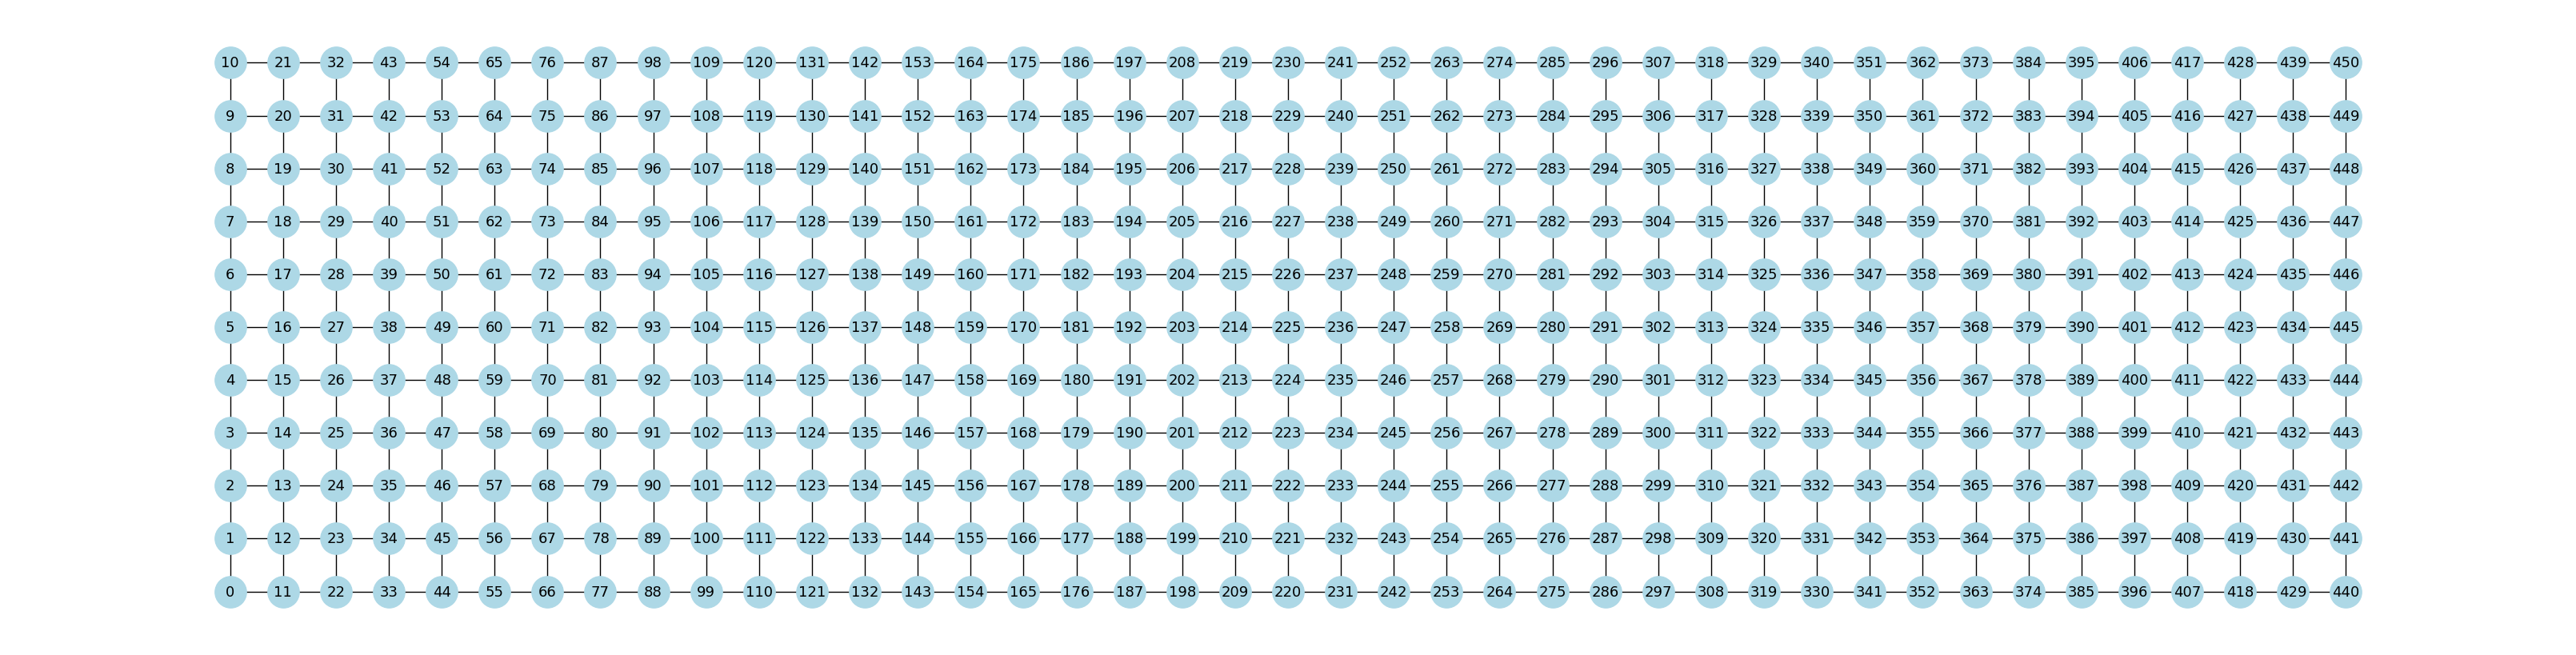

In [ ]:
num_elements = [20,5]  # Length of the beam
num_nodes = [2*num_elements[0]+1,2*num_elements[1]+1]  # Number of elements
beam_graph = create_cantilever_beam_graph(num_nodes, df,1)
assign_node_features(beam_graph,1)
label = generate_labels(beam_graph,1)
node_df = (pd.DataFrame.from_dict(dict(beam_graph.nodes(data=True)), orient='index'))['feature']
node = []
for j in range(len(node_df)):
  node.append(list(node_df[0].values()))
node = tf.cast(node, dtype=tf.dtypes.float32)
edge_df = nx.to_pandas_edgelist(beam_graph)
edge_df = edge_df.to_numpy().T
edge_weights = None
graph_info = (node, edge_df, edge_weights)
visualise(beam_graph)

In [ ]:
class GNNNodedisplacement(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(2,activation = 'linear')

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        #input_node_indices = [tf.cast(x, tf.int32) for x in input_node_indices]
        #input_node_indices = [tf.cast(input_node_indices, tf.int32)][]
        #print(type(input_node_indices))
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        #print(x.shape)
        node_embeddings = tf.gather(x, [450])
        #print(node_embeddings.shape)
        # Compute logits
        #return x
        return self.compute_logits(node_embeddings)

## Training and testing the model

In [ ]:
x_train = []
y_train = []
for i in range(df.shape[0]):
  x = (df[' X-co']).tolist()[i]
  y = (df[' Y-co']).tolist()[i]
  E1 = (df['E1']).tolist()[i]
  E2 = (df['E2']).tolist()[i]
  E3 = (df['E3']).tolist()[i]
  E4 = (df['E4']).tolist()[i]
  ux = (df['Ux']).tolist()[i]
  uy = (df['Uy']).tolist()[i]
  poisson = (df['poisson']).tolist()[i]
  x_train.append([x,y,E1,E2,E3,E4,poisson])
  y_train.append([ux*1e7,uy*1e7])

In [ ]:
x_test,y_test = x_train[int(-0.2*len(x_train)):], y_train[int(-0.2*len(y_train)):]
x_train,y_train = x_train[0:int(0.8*len(x_train))], y_train[0:int(0.8*len(y_train))]
print(len(x_train),len(x_test))

3608 902


In [ ]:
hidden_units = [32,32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = 40
num_features = len(x_train[0])
num_classes = 1

In [ ]:
gnn_model = GNNNodedisplacement(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1,10]))

gnn_model.summary()

GNN output shape: tf.Tensor([[8.901165e+09 5.840761e+09]], shape=(1, 2), dtype=float32)
Model: "gnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess (Sequential)     (451, 32)                 1360      
                                                                 
 graph_conv1 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 graph_conv2 (GraphConvLayer  multiple                 5888      
 )                                                               
                                                                 
 postprocess (Sequential)    (451, 32)                 2368      
                                                                 
 dense_12 (Dense)            multiple                  66        
                                   

In [ ]:
baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_features (InputLayer)    [(None, 7)]          0           []                               
                                                                                                  
 ffn_block1 (Sequential)        (None, 32)           1468        ['input_features[0][0]']         
                                                                                                  
 ffn_block2 (Sequential)        (None, 32)           2368        ['ffn_block1[0][0]']             
                                                                                                  
 skip_connection2 (Add)         (None, 32)           0           ['ffn_block1[0][0]',             
                                                                  'ffn_block2[0][0]']      

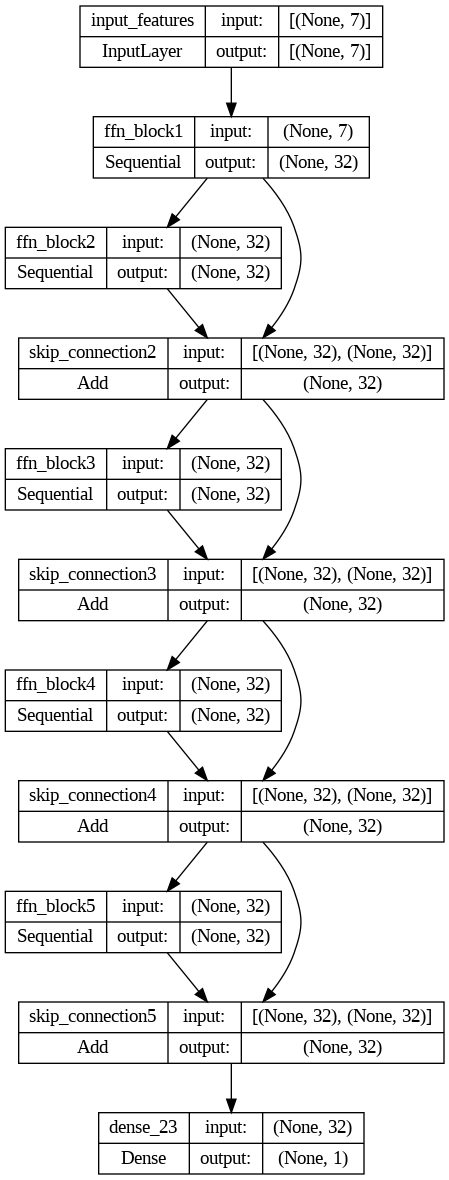

In [ ]:
plot_model(baseline_model, show_shapes=True, show_layer_names=True, dpi=96, to_file="baseline_model.png")

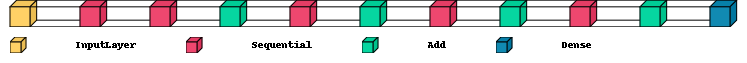

In [ ]:
image = visualkeras.layered_view(baseline_model, spacing=50,legend=True )
image # display the image
#image.save("baseline_model_2.png") # save the image


### Train the model

In [ ]:
# Plot training loss
def plot(history,modelname):
  plt.plot(history.history['loss'])
  plt.title(modelname)
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.show()

In [ ]:
historygnn = run_experiment(gnn_model, x_train, y_train)

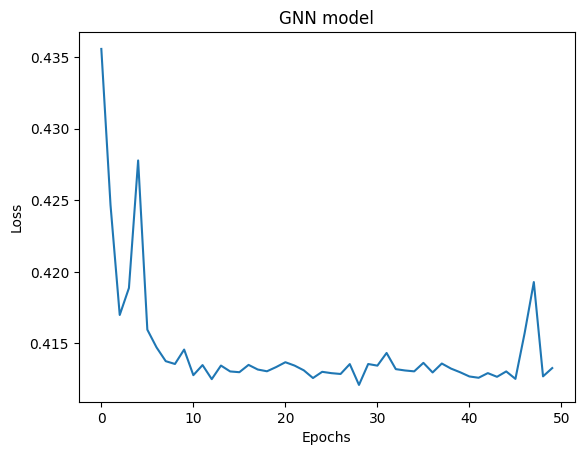

In [ ]:
plot(historygnn,"GNN model")

In [ ]:
historyfnn = run_experiment(baseline_model, x_train, y_train)

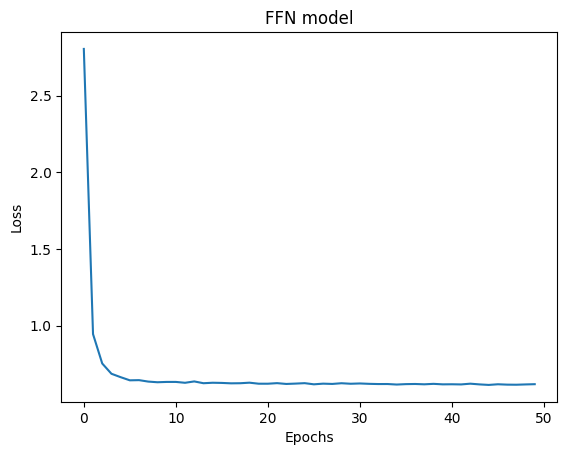

In [ ]:
plot(historyfnn,"FFN model")

## Conclusion

After changing various parameters, we concluded that GNN model is not very efficient for value prediction as compared to simple NN and takes larger amount of time to train the model. The same can see from the Loss vs Epochs Graph of the two models.
From the literature review, we found out that GNN model is much more efficient for classification problem.

Ref: https://keras.io/examples/graph/gnn_citations/